### ex8 Anomaly detection

We will implement the anomaly detection algorithm and apply it to detect failing servers on a network. The features measures the through put and latencey of response of each server. While your servers are operating, you collect m=307 examples of how they were operating and thus have an unlabeled data set {x^1, x^2, ..., x^m}. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math
from scipy.optimize import minimize
from scipy.io import loadmat

#### Part 1: Load Example Dataset  

We start this exercise by using a small dataset that is easy to visualize.
Our example case consists of 2 network server statistics across several machines: the latency and throughput of each machine. We will find possibly faulty (or very fast) machines.

In [2]:
data1=loadmat('ex8data1.mat'); # load in a dictionary
print(data1.keys())
X=data1['X']
Xval=data1['Xval']
yval=data1['yval']
print(X.shape)

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])
(307, 2)


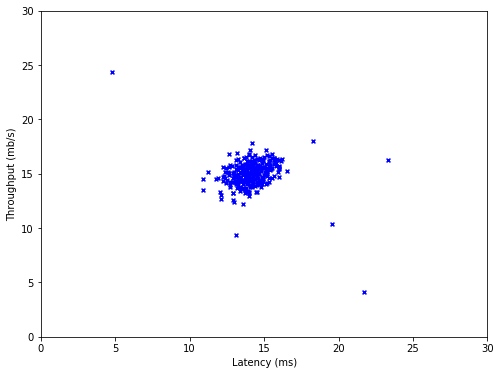

In [110]:
#  Visualize the example dataset
plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1], color='b', marker='x',s=15);
plt.axis([0, 30, 0, 30]);
plt.xlabel('Latency (ms)');
plt.ylabel('Throughput (mb/s)');

#### Part 2: Estimate the dataset statistics

For this exercise, we assume a Gaussian distribution for the dataset.

We first estimate the parameters of our assumed Gaussian distribution, then compute the probabilities for each of the points and then visualize both the overall distribution and where each of the points falls in terms of that distribution.

In [3]:
mu=X.mean(axis=0)
Sigma2=X.var(axis=0)
print(mu)
print(Sigma2)

[14.11222578 14.99771051]
[1.83263141 1.70974533]


In [30]:
def multivariateGaussian(X, mu, Sigma2):
#    p = MULTIVARIATEGAUSSIAN(X, mu, Sigma2) Computes the probability 
#    density function of the examples X under the multivariate gaussian 
#    distribution with parameters mu and Sigma2. If Sigma2 is a matrix, it is
#    treated as the covariance matrix. If Sigma2 is a vector, it is treated
#    as the sigma^2 values of the variances in each dimension (a diagonal
#    covariance matrix)
    k = mu.size;
    mu=mu.reshape((1,-1))
    if Sigma2.ndim==1:
        Sigma2 = np.diag(Sigma2);
    cons=(2 * math.pi)**(- k / 2) * np.linalg.det(Sigma2)**(-0.5)
    exp=np.exp((-0.5*(((X-mu).dot(np.linalg.inv(Sigma2))))*((X-mu))).sum(axis=1))
    p = cons*exp
    
    return p

In [31]:
#  Returns the density of the multivariate normal at each data point (row) of X
p = multivariateGaussian(X, mu, Sigma2);

In [53]:
def visualizeFit(X, mu, Sigma2):
    #   VISUALIZEFIT(X, p, mu, sigma2) This visualization shows you the 
    #   probability density function of the Gaussian distribution. Each example
    #   has a location (x1, x2) that depends on its feature values.
    X1,X2 = np.meshgrid(np.arange(0, 35.1, 0.5), np.arange(0, 35.1, 0.5))
    m=X1.shape[0]
    Z = multivariateGaussian(np.column_stack((X1.reshape(X1.size, order='F'), X2.reshape(X2.size, order='F'))), mu, Sigma2)
    Z = Z.reshape(X1.shape, order='F')
    plt.scatter(X[:, 0], X[:, 1], s=150, c='b', marker='x', linewidths=1)
    plt.hold(True)
    # Draw the contour plot at the below specified level
    plt.contour(X1, X2, Z, np.power(10,(np.arange(-20, 0.1, 3)).T))
    plt.hold(False)

C:\Users\zhang\Anaconda3 new\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\zhang\Anaconda3 new\lib\site-packages\matplotlib\__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\zhang\Anaconda3 new\lib\site-packages\matplotlib\rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)
C:\Users\zhang\Anaconda3 new\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  del sys.

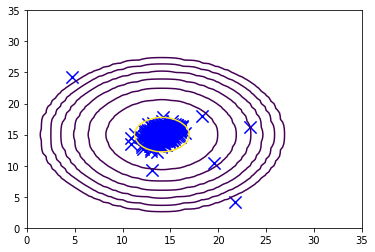

In [54]:
visualizeFit(X, mu, Sigma2)

#### Part 3: Find Outliers 

Now we will find a good epsilon threshold using a cross-validation set probabilities given the estimated Gaussian distribution

In [55]:
pval = multivariateGaussian(Xval, mu, Sigma2);

In [57]:
def selectThreshold(yval, pval):
    
    #   [bestEpsilon bestF1] = SELECTTHRESHOLD(yval, pval) finds the best
    #   threshold to use for selecting outliers based on the results from a
    #   validation set (pval) and the ground truth (yval).
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0
    yval=yval.flatten()
    stepsize = (max(pval) - min(pval)) / 1000
    for epsilon in np.arange(min(pval), max(pval), stepsize):
        cvPredictions = pval < epsilon

        # calculate F1 score, starting by calculating true positives(tp), false positives (fp) and false negatives (fn)
        tp = np.sum(np.logical_and((cvPredictions==1), (yval==1)).astype(float))
        fp = np.sum(np.logical_and((cvPredictions==1), (yval==0)).astype(float))
        fn = np.sum(np.logical_and((cvPredictions==0), (yval==1)).astype(float))

        # compute precision, recall and F1
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        F1 = (2*precision*recall)/(precision+recall)

        if F1 > bestF1:
           bestF1 = F1
           bestEpsilon = epsilon

    return bestEpsilon, bestF1

In [62]:
epsilon, F1 = selectThreshold(yval, pval);
print('Best epsilon found using cross-validation: ', epsilon);
print('Best F1 on Cross Validation Set:  ', F1);
print('   (you should see a value epsilon of about 8.99e-05)\n');
print('   (you should see a Best F1 value of  0.875000)\n\n');

Best epsilon found using cross-validation:  8.990852779269495e-05
Best F1 on Cross Validation Set:   0.8750000000000001
   (you should see a value epsilon of about 8.99e-05)

   (you should see a Best F1 value of  0.875000)




C:\Users\zhang\Anaconda3 new\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


In [64]:
#  Find the outliers in the training set and plot the
outliers = p < epsilon;
outliers

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

C:\Users\zhang\Anaconda3 new\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\zhang\Anaconda3 new\lib\site-packages\matplotlib\__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\zhang\Anaconda3 new\lib\site-packages\matplotlib\rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)
C:\Users\zhang\Anaconda3 new\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  del sys.

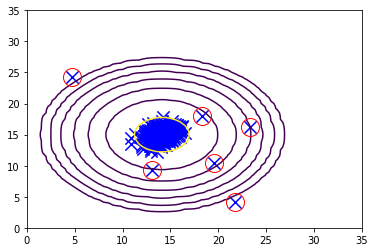

In [67]:
visualizeFit(X, mu, Sigma2)
plt.hold(True)
#  Draw a red circle around those outliers
plt.plot(X[outliers, 0], X[outliers, 1], 'ro', linewidth=2, markersize=18, fillstyle='none', markeredgewidth=1)
plt.hold(False)

#### Part 4: Multidimensional Outliers 

We will now use the code from the previous part and apply it to a harder problem in which more features describe each datapoint and only some features indicate whether a point is an outlier.

Loads the second dataset.

In [68]:
data2=loadmat('ex8data2.mat');
print(data2.keys())
X=data2['X']
Xval=data2['Xval']
yval=data2['yval']

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])


In [69]:
yval.shape

(100, 1)

In [72]:
#  Apply the same steps to the larger dataset
mu=X.mean(axis=0)
sigma2=X.var(axis=0)

#  Training set 
p = multivariateGaussian(X, mu, sigma2);

#  Cross-validation set
pval = multivariateGaussian(Xval, mu, sigma2);

#  Find the best threshold
[epsilon, F1] = selectThreshold(yval, pval);

print('Best epsilon found using cross-validation: ', epsilon);
print('Best F1 on Cross Validation Set:  ', F1);
print('   (you should see a value epsilon of about 1.38e-18)\n');
print('   (you should see a Best F1 value of 0.615385)\n');
print('# Outliers found: ', np.sum(p < epsilon));
print('The F1 score is: ', F1)

Best epsilon found using cross-validation:  1.377228890761358e-18
Best F1 on Cross Validation Set:   0.6153846153846154
   (you should see a value epsilon of about 1.38e-18)

   (you should see a Best F1 value of 0.615385)

# Outliers found:  117
The F1 score is:  0.6153846153846154


C:\Users\zhang\Anaconda3 new\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
